In [ ]:
# Step 1.1: Install required libraries
!pip install rasterstats geopandas rasterio shapely pyproj openpyxl tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 69.6 MB/s eta 0:00:00


In [ ]:
# Step 1.2: Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Step 1.3: Define target species
target_species = {
    "axolotl": "Ambystoma mexicanum",
    "blue_macaw": "Anodorhynchus hyacinthinus",
    "ocelot": "Leopardus pardalis",
    "black_iguana": "Ctenosaura pectinata",
    "resplendent_quetzal": "Pharomachrus mocinno",
    "coyote": "Canis latrans",
    "crested_caracara": "Caracara cheriway",
    "green_turtle": "Chelonia mydas",
    "american_alligator": "Alligator mississippiensis",
    "asian_elephant": "Elephas maximus"
}

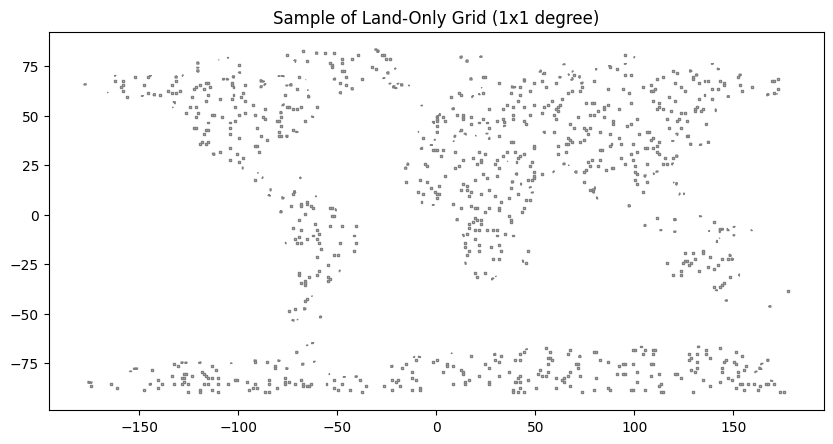

Filtered land-only grid cells: 24320


In [ ]:
# Step 2: Create land-only grid
def create_grid(bounds, cell_size_deg=1.0):
    minx, miny, maxx, maxy = bounds
    grid_cells = []
    for x0 in np.arange(minx, maxx, cell_size_deg):
        for y0 in np.arange(miny, maxy, cell_size_deg):
            x1 = x0 + cell_size_deg
            y1 = y0 + cell_size_deg
            grid_cells.append(box(x0, y0, x1, y1))
    return gpd.GeoDataFrame({'geometry': grid_cells}, crs="EPSG:4326")

global_bounds = [-180.0, -90.0, 180.0, 90.0]
grid_gdf = create_grid(global_bounds)

# Step 2.1: Filter ocean cells

land_gdf = gpd.read_file("ne_110m_land/ne_110m_land.shp").to_crs(grid_gdf.crs)
grid_gdf = gpd.overlay(grid_gdf, land_gdf, how="intersection")
grid_gdf = grid_gdf[['geometry']]
grid_gdf.sample(1000).plot(edgecolor="gray", facecolor="none", figsize=(10, 6))
plt.title("Sample of Land-Only Grid (1x1 degree)")
plt.show()
print(f"Filtered land-only grid cells: {len(grid_gdf)}")

In [ ]:
# Step 3: Load GBIF species occurrence CSVs
species_files = {
    "axolotl": "axolotl.csv",
    "blue_macaw": "bluemacaw.csv",
    "ocelot": "ocelot.csv",
    "black_iguana": "blackiguana.csv",
    "resplendent_quetzal": "quetzal.csv",
    "coyote": "coyote.csv",
    "crested_caracara": "crestedcaracara.csv",
    "green_turtle": "greenturtle.csv",
    "american_alligator": "americanalligator.csv",
    "asian_elephant": "asianelephant.csv"
}
dfs = []
for species, file in species_files.items():
    df = pd.read_csv(file, sep="\t", quotechar='"', low_memory=False, on_bad_lines='skip')
    df = df[['decimalLatitude', 'decimalLongitude', 'eventDate', 'scientificName']].dropna()
    df['species_label'] = species
    dfs.append(df)
gbif_df = pd.concat(dfs, ignore_index=True)
print(f"Combined GBIF dataset shape: {gbif_df.shape}")

Combined GBIF dataset shape: (447564, 5)


In [ ]:
# Step 4: Spatial join and species aggregation
geometry = [Point(xy) for xy in zip(gbif_df['decimalLongitude'], gbif_df['decimalLatitude'])]
gbif_gdf = gpd.GeoDataFrame(gbif_df, geometry=geometry, crs="EPSG:4326")
gbif_with_grid = gpd.sjoin(gbif_gdf, grid_gdf, how="inner", predicate="within")
species_counts = gbif_with_grid.groupby(['index_right', 'species_label']).size().unstack(fill_value=0)
grid_with_species = grid_gdf.join(species_counts, how="left").fillna(0)
grid_with_species.head()

,geometry,american_alligator,asian_elephant,axolotl,black_iguana,blue_macaw,coyote,crested_caracara,green_turtle,ocelot,resplendent_quetzal
0,"POLYGON ((-179 -89, -179 -90, -180 -90, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-179 -88, -179 -89, -180 -89, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-179 -87, -179 -88, -180 -88, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-179 -86, -179 -87, -180 -87, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-179 -85, -179 -86, -180 -86, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Step 5: Spatial join with WWF Biomes
wwf_gdf = gpd.read_file("wwf/wwf_terr_ecos.shp").to_crs("EPSG:4326")
grid_with_biome = gpd.sjoin(grid_with_species, wwf_gdf[['BIOME', 'geometry']], how="left", predicate="intersects")
grid_with_biome['BIOME'] = grid_with_biome['BIOME'].fillna("Unknown")
grid_with_biome[['BIOME']].value_counts().head()

,count
BIOME,
11.0,7013
1.0,6364
99.0,6217
13.0,5044
4.0,4144


In [ ]:
# Step 6: Extract climatic variables using zonal statistics
import os
from rasterstats import zonal_stats

clim_dir = "worldclim/"
bio_vars = [1, 4, 5, 6, 12, 15, 17, 18]
clim_features = {}
for var in bio_vars:
    tif_path = os.path.join(clim_dir, f"wc2.1_10m_bio_{var}.tif")
    stats = zonal_stats(
        grid_with_biome["geometry"],
        tif_path,
        stats=["mean"],
        nodata=-9999,
        geojson_out=False
    )
    clim_features[f"BIO{var}"] = [s["mean"] if s else None for s in stats]
for col, values in clim_features.items():
    grid_with_biome[col] = values
grid_with_biome.head()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_m

,geometry,american_alligator,asian_elephant,axolotl,black_iguana,blue_macaw,coyote,crested_caracara,green_turtle,ocelot,...,index_right,BIOME,BIO1,BIO4,BIO5,BIO6,BIO12,BIO15,BIO17,BIO18
0,"POLYGON ((-179 -89, -179 -90, -180 -90, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14333.0,99.0,-34.059967,901.148058,-15.907215,-47.331716,39.527778,137.171861,0.0,0.0
1,"POLYGON ((-179 -88, -179 -89, -180 -89, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14333.0,99.0,-40.157861,1028.988281,-19.291133,-55.294576,43.555556,136.542480,0.0,0.0
2,"POLYGON ((-179 -87, -179 -88, -180 -88, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14333.0,99.0,-41.340054,1063.361979,-19.728048,-57.269572,46.666667,128.645345,0.0,0.0
3,"POLYGON ((-179 -86, -179 -87, -180 -87, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14333.0,99.0,-40.394711,1068.410373,-18.713645,-56.581011,54.888889,121.148248,0.0,0.0
3,"POLYGON ((-179 -86, -179 -87, -180 -87, -180 -...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14420.0,11.0,-40.394711,1068.410373,-18.713645,-56.581011,54.888889,121.148248,0.0,0.0


In [ ]:
# Step 7: Final cleaning and export
df_cleaned = grid_with_biome.drop(columns=["geometry", "index_right"], errors='ignore')

# Step 7.1: Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Step 7.2: Identify species and environmental columns
species_cols = list(target_species.keys())
env_cols = [col for col in df_cleaned.columns if col.startswith("BIO")]

# Step 7.3: Ensure BIO variables are numeric and impute missing values
df_cleaned[env_cols] = df_cleaned[env_cols].apply(pd.to_numeric, errors='coerce')
print("Missing values per column (after coercion):")
print(df_cleaned[env_cols].isna().sum())
df_cleaned[env_cols] = df_cleaned[env_cols].fillna(df_cleaned[env_cols].mean())

# Step 7.4: Convert species columns to binary presence/absence
df_cleaned[species_cols] = df_cleaned[species_cols].map(lambda x: 1 if x > 0 else 0)

# Step 7.5: Remove rows with no species present at all
df_cleaned = df_cleaned[df_cleaned[species_cols].sum(axis=1) > 0]

# Step 7.6: Optional: Handle missing biome
df_cleaned["BIOME"] = df_cleaned["BIOME"].fillna("Unknown")

# Step 7.7: Export cleaned dataset
df_cleaned.to_csv("species_biome_env_dataset.csv", index=False)
print("Dataset exported! Final shape:", df_cleaned.shape)

<ipython-input-41-1cea3cbf9af9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[env_cols] = df_cleaned[env_cols].apply(pd.to_numeric, errors='coerce')


Missing values per column (after coercion):
BIOME    15
BIO1     45
BIO4     45
BIO5     45
BIO6     45
BIO12    45
BIO15    45
BIO17    45
BIO18    45
dtype: int64
✅ Dataset exported! Final shape: (4461, 19)


<ipython-input-41-1cea3cbf9af9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["BIOME"] = df_cleaned["BIOME"].fillna("Unknown")
